## Load (generated) data

In [1]:
import pandas as pd

C:\Users\rmeer\AppData\Local\Temp\ipykernel_35544\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('exported_data_biased.csv', index_col = 'Unnamed: 0')

## Data Description
Dataframe "df" contains information about athletes (denoted by "user_id") over time (denoted by "date") during a 2 year period.
It contains a column "injury_onset" (Boolean) that indicates whether that athlete got injured on that day.
The column "to_be_injured" contains either 0s, 1s or NA (int64) and can be used for (logistic) regression.
The column "currently_injured" (Boolean) denotes whether the athlete is (still) injured on that day.
Each injury period is denoted by a unique identifier ("injury_idx", string).
There is also a helper column "days_until_next_injury" that denotes the number of days until the next injury.
And there is a helper column "next_injury_idx" that indicates what the injury_idx is of that upcoming injury.
There is a helper column "days_since_prev_injury_end" indicating the number of days since the previous injury.
There are also three Boolean columns that indicate an upcoming injury: upcoming_injury_within_28_days, upcoming_injury_within_14_days, upcoming_injury_within_07_days.

Each practice (max 1 per day) has an "rpe" (1-10) and a duration ("duration_minutes").
The distribution of the rpes is characterized by "training_distribution" (pyramidal or polarized).

Each practice day is also characterized by "session_rpe" (rpe * duration_minutes).
Each day is also characterized by:
     session_rpe_SUM_07_days: The sum of session_rpe in the past 7 days.
     session_rpe_STD0_07_days: The standard deviation of session_rpe in the past 7 days where days without practice have been assigned a 0.
     session_rpe_SUM_28_days: The sum of session_rpe in the past 28 days.
     session_rpe_STD0_28_days: The standard deviation of session_rpe in the past 28 days where days without practice have been assigned a 0.
     session_rpe_AC07_28_days: The acute (past 7 days) chronic (past 28 days) workload ratio. Values below 1 denote relative undertraining, above 1 overtraining.
     session_rpe_MON_28_days: the monotony of the past 28 days
     session_rpe_STR_28_days: the strain of the past 28 days

There are some metrics (1-10) that quantify the athlete's wellbeing: "Energy Score",	"Mood Score", "Recovery Score", "Motivation Score", "Confidence Score", "Sleep Quality Score".'
These metrics have been summarized for each day by taking the average ("Wellness Average").

Most importantly, it contains a set of columns with the suffix "_AVG_prev_07_days" that summarize the 7 days preceding the current day.
These columns should be used in combination for any predictions of to_be_injured.

## Question 1: 
## I'm a coach and I want to improve my training schedules. Suggest me some analyses with the described data.


In [9]:
# Question: I'm a coach and I want to improve my training schedules. Suggest me some analyses with the described data.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.stats import ttest_ind, mannwhitneyu

# Load your dataset
df = pd.read_csv('exported_data_biased.csv', index_col = 'Unnamed: 0')

# Filter only relevant columns
columns = [
    "session_rpe_AC07_28_days", "session_rpe_MON_28_days", "session_rpe_STR_28_days",
    "to_be_injured", 'currently_injured', 'upcoming_injury_within_28_days'
]
df_filtered = df[columns].dropna()

# Basic stats
print(df_filtered.describe())

       session_rpe_AC07_28_days  session_rpe_MON_28_days  \
count               4401.000000              4401.000000   
mean                   1.002985                 0.857091   
std                    0.419237                 0.126689   
min                    0.000000                 0.557438   
25%                    0.708807                 0.764613   
50%                    0.997866                 0.847049   
75%                    1.284613                 0.941991   
max                    2.474764                 1.409772   

       session_rpe_STR_28_days  to_be_injured  
count              4401.000000         4401.0  
mean               3405.514044            0.0  
std                1327.787725            0.0  
min                 654.242263            0.0  
25%                2420.725566            0.0  
50%                3291.273007            0.0  
75%                4166.567444            0.0  
max               10232.128667            0.0  


In [8]:
# Define injury groups
injured = df_filtered[(df_filtered["to_be_injured"] == 1)]
not_injured = df_filtered[(df_filtered["to_be_injured"] == 0)]

# Boxplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = ["session_rpe_AC07_28_days", "session_rpe_MON_28_days", "session_rpe_STR_28_days"]

for i, metric in enumerate(metrics):
    sns.boxplot(data=df_filtered, x="injury_onset", y=metric, ax=axes[i])
    num_injured = len(injured)
    num_not_injured = len(not_injured)
    axes[i].set_xticklabels([f"Not Injured\n(n={num_not_injured})", f"Injured\n(n={num_injured})"])
    axes[i].set_title(f"{metric} by Injury Onset")

plt.tight_layout()
plt.show()


KeyError: 'to_be_injured'

In [7]:
for metric in metrics:
    cur_injured = injured.loc[injured[metric].notnull(),:]
    cur_notinjured = not_injured.loc[not_injured[metric].notnull(),:]
    if cur_injured[metric].empty:
        print(f'no injuries (metric {metric}).. cant plot it')
        continue
    stat, p_val = ttest_ind(cur_injured[metric], cur_notinjured[metric], equal_var=False)
    print(f"{metric}: t-test p-value = {p_val:.5f}")

    # If non-normal distribution, use Mann-Whitney U test
    stat, p_val = mannwhitneyu(cur_injured[metric], cur_notinjured[metric])
    print(f"{metric}: Mann-Whitney U p-value = {p_val:.5f}\n")


no injuries (metric session_rpe_AC07_28_days).. cant plot it
no injuries (metric session_rpe_MON_28_days).. cant plot it
no injuries (metric session_rpe_STR_28_days).. cant plot it


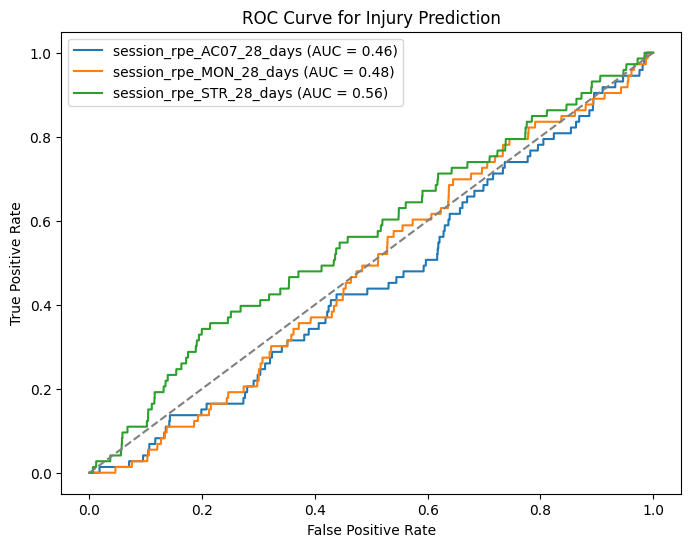

In [ ]:
plt.figure(figsize=(8, 6))

for metric in metrics:
    fpr, tpr, thresholds = roc_curve(df_filtered["injury_onset"], df_filtered[metric])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{metric} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Injury Prediction")
plt.legend()
plt.show()


In [ ]:
optimal_thresholds = {}
for metric in metrics:
    fpr, tpr, thresholds = roc_curve(df_filtered["injury_onset"], df_filtered[metric])
    optimal_idx = np.argmax(tpr - fpr)  # Maximize True Positive Rate - False Positive Rate
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold for {metric}: {optimal_threshold:.2f}")
    optimal_thresholds[metric] = optimal_threshold


Optimal threshold for session_rpe_AC07_28_days: 0.14
Optimal threshold for session_rpe_MON_28_days: 0.76
Optimal threshold for session_rpe_STR_28_days: 4281.53


In [ ]:
for metric, thresh in optimal_thresholds.items():
    df_filtered[f"{metric}_high_risk"] = df_filtered[metric] > thresh

# Calculate probability of injury for high-risk athletes
for metric in metrics:
    risk_group = df_filtered[df_filtered[f"{metric}_high_risk"]]
    injury_prob = risk_group["injury_onset"].mean()
    print(f"Probability of injury when {metric} > {optimal_thresholds[metric]:.2f}: {injury_prob:.2%}")

Probability of injury when session_rpe_AC07_28_days > 0.14: 0.91%
Probability of injury when session_rpe_MON_28_days > 0.76: 0.97%
Probability of injury when session_rpe_STR_28_days > 4281.53: 1.49%
